## Metropolis Hastings Markov Chain and Evolutionary Monte Carlo Implementations 

In this notebook, we will implement two Monte Carlo optimization routines and output comparative metrics to explore a given fitness landscape. The fitness landscape of interest will be generated by a machine learning model and is outside the scope of this notebook. Here, we are concerned with implementation of the Monte Carlo routines for a given sequence. 

In [1]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import random
import itertools

from explore_fitness import *

### Metropolis Hastings Markov Chain Monte Carlo Algorithm

(Tim) 
1. Propose new sequence S_i with fitness f(S_i)
2. If f(S_i) > f(S_i-1) move to the new sequence.  Otherwise we move with probability equal to exp((f(Si-1) - f(Si))/T) for some fixed temperature parameter T.  If the fitness of the new sequence is close to the old we are more likely to move.  If the fitness is significantly decreased we don’t move.
3. Repeat 

Ideally, the algorithm converges to a sequence with optimal fitness that doesn't change for a given number of iterations. 

### Toy fitness model 

To test the implementation of MH-MCMC, we will use a simple toy fitness model (called toy_fitness_1) which maximizes the number of alanines and glycines in a given sequence. Therefore, for any given sequence, the MH-MCMC should converge to a sequence of purely alanines and glycines after a large number of iterations. Later, we can test more complicated toy fitness models, ideally those already developed by XGBoost applied to ESM2 embedded sequences. 

### Mutation Operator/Sequence Generator

The second part of the algorithm requires us to propose a new sequence, we will do that by making random single mutations anywhere along the sequence. In this notebook, the locus and the choice of mutation are generated using a uniform random distribution.

### Move Evaluator

If the new proposed sequence has a fitness that is better than the old sequence, then the new sequence is always accepted, if not, then the new sequence is only accepted with the probability proportional to the difference between the two fitnesses. 

In [2]:
sequence = generate_random_sequence(15)

worst_fitness_example = 'VVVVVVVVVVVVVVV'
best_fitness_example  = 'AAGGAAGGAAGGAAG'

#toy_fitness_1(mutate_seq(sequence))
#print(toy_fitness_1(sequence))
print('Best possible fitness is using toy_fitness_1 is:',toy_fitness_1(best_fitness_example))
print('Worst possible fitness is using toy_fitness_1 is:',toy_fitness_1(worst_fitness_example))

Best possible fitness is using toy_fitness_1 is: 1.0
Worst possible fitness is using toy_fitness_1 is: -0.03208323811780601


### How do we gauge convergence? 

In this case, let's take convergence to be when our fitness is over 0.95. This is an over-simplication since we are using a toy model with a known maximum (1), achievable, fitness. With more complicated fitness functions, we can adapt the convergence condition. Often, for XGB and CNN classifiers, the fitness scores range between 0 and 1. 

Most of the time, when the inherent nature of the fitness landscape is unknown, convergence is usually gauged by plotting the fitness function over the iterations and looking for a plateau. Here we plot the evolution of the fitness function over a range of temperatures to demonstrate (and confirm) that the temperature is the parameter that determines how eager the algorithm is to explore the landscape. 

Let us now write a function for MH_MCMC

### Temperature

Here, we will demonstrate that the temperature is the key variable that determines how liberal our model would be to accepting new moves for a given fitness landscape. Since this is not a 'physical' system, in that our fitness landscape is not a physical energy landscape where the energies are tied to an observable force, our choice of temperature is arbitrary, and by playing around with it we can observe how the algorithm explores the space by looking at the 'width' of the fluctuations. 

'GGAAGAAGAAGAGAAAGGAAAAGSGGGAAGGGGAG'

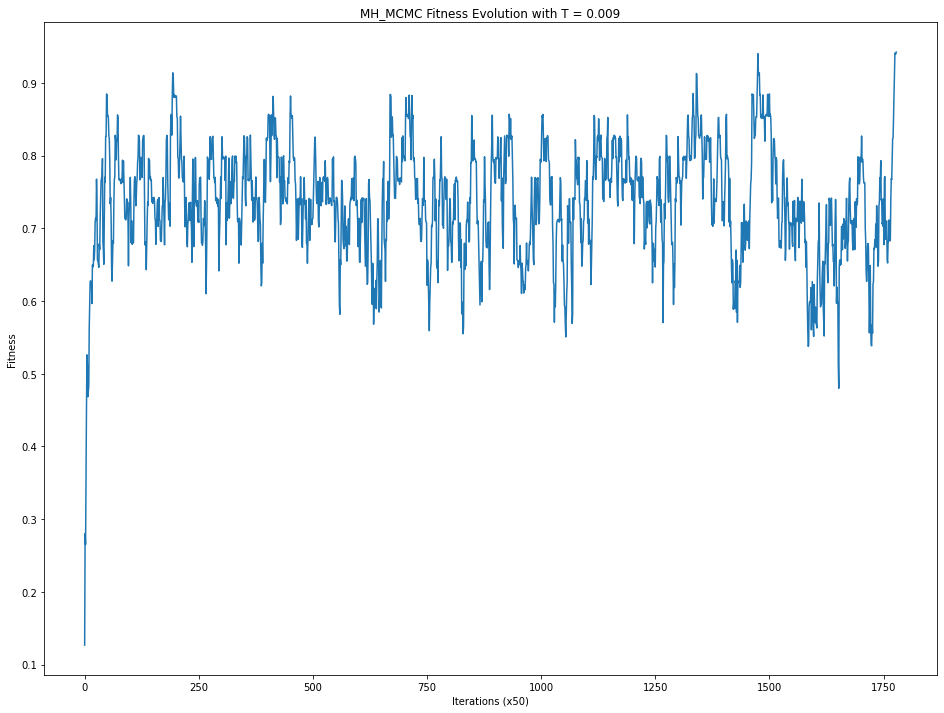

In [3]:
no_of_iterations = 10**7 #10 million

MH_MCMC(generate_random_sequence(35), toy_fitness_1, no_of_iterations, 
        convergence_known = True, plot_fitness = True, temp = 0.009, verbose = False)[0]

'AAAAGAHAGGGAGGAAGGAAGGAAAAAAGAGAAGA'

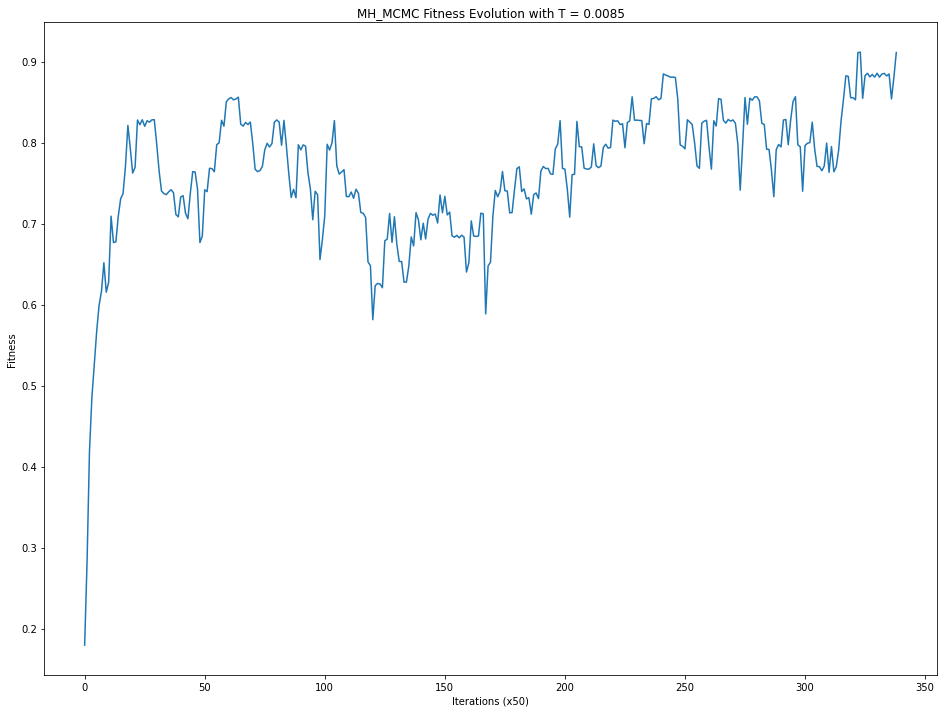

In [4]:
MH_MCMC(generate_random_sequence(35), toy_fitness_1, no_of_iterations, 
        convergence_known = True, plot_fitness = True, temp = 0.0085, verbose = False)[0]

'AAAAGGAGGAAAAGAGAGAAAAGGGPAAGAAAAGG'

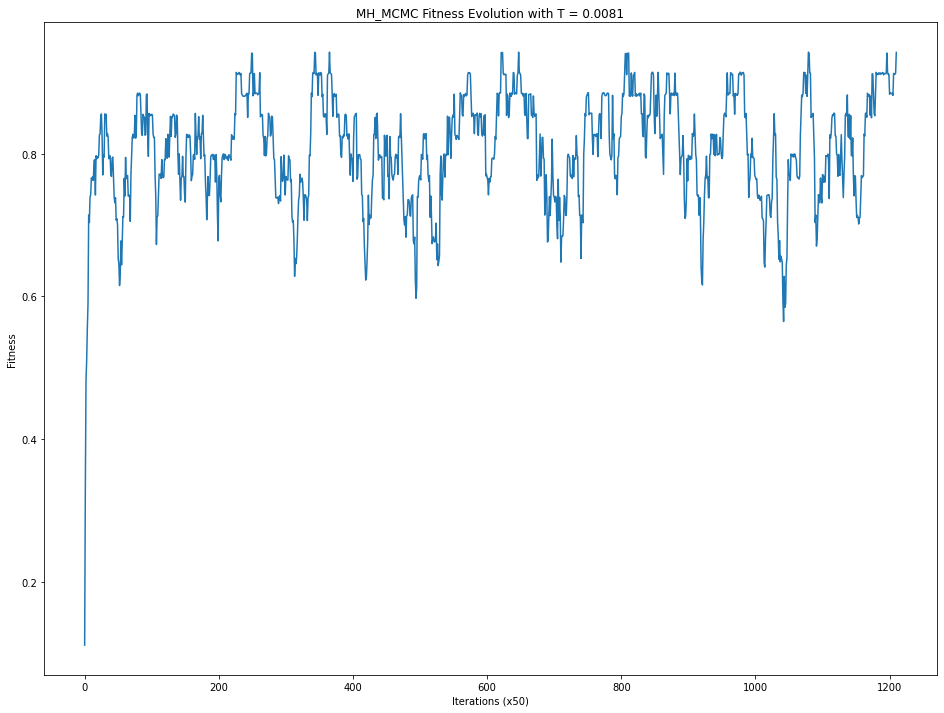

In [5]:
MH_MCMC(generate_random_sequence(35), toy_fitness_1, no_of_iterations, 
        convergence_known = True, plot_fitness = True, temp = 0.0081, verbose = False)[0]

## Considerations

We can see that convergence can be achieved with toy_fitness_1 up to 50 amino acid sequences (not shown here for neatness). We can theoretically have even longer sequences if we eliminate noise from our fitness function, or if we reduced noise so that the improvement to the fitness due to a single mutation is greater than the noise. 

So to test our MH_MCMC algorithm further, let us try one more fitness function, with known maximums, but also where the jumps in fitness are larger. With a more conservative approach to noise, we are able to achieve convergence for even longer sequences (up to 1000 - later shown in the notebook).

In algorithms like these where the temperature is arbitrary, there is usually some kind of convention used to determine the temperature, usually, the temperature is chosen such that about 5-25% of non-ideal moves (moves in which the fitness function is increased) are accepted. For evolutionary MCMC and other algorithms motivated by replica-exchange/parellel tempering, there are [studies](https://academic.oup.com/mnras/article/455/2/1919/1118710) to help decide the ideal temperature range for efficient sampling.

'AGMAGAGAGAGVCAGVCAGVCAGAGAGVCVCAGAGVCVCAGVCAGKAGVCVCAGAGVCAGAGVCVCVCAGAGVCVCVCAGVCAGVCAGAGVCVCAGAGAG'

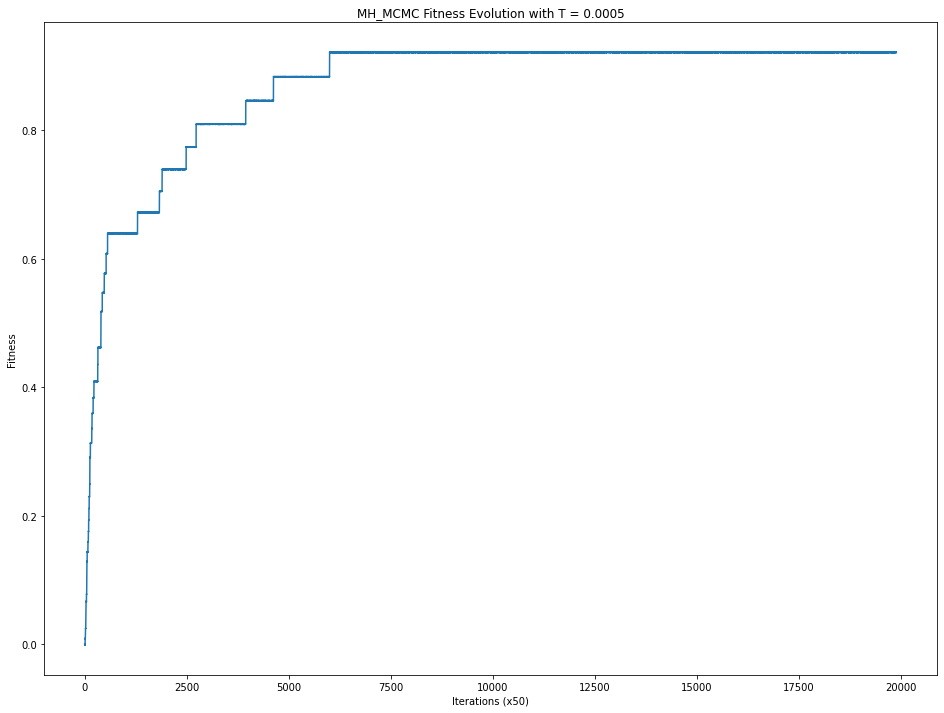

In [6]:
sequence = generate_random_sequence(100)
MH_MCMC(sequence, toy_fitness_2, no_of_iterations,
        convergence_known = True, plot_fitness = True, 
        verbose = False, temp = 5e-4)[0]

'AGAGVCAGVCVCKVCVCAGVCAGAGAGVCVCAGAGAGAGVCAGAGAGVCAGVCVCAGVCVCDAGVCVCAGAGAGVCAGVCVCAGAGAGAGAGAGAGVCAGVCVCAGAGVCAGVCAGVCVCVVCAGAGAGAGAGAGAGVCVCVCAGAGAGVCVCVCVCAGVCAGVCHVCVCVCVCVCAGAGAGVCVCAGAGVCVCAGAGVC'

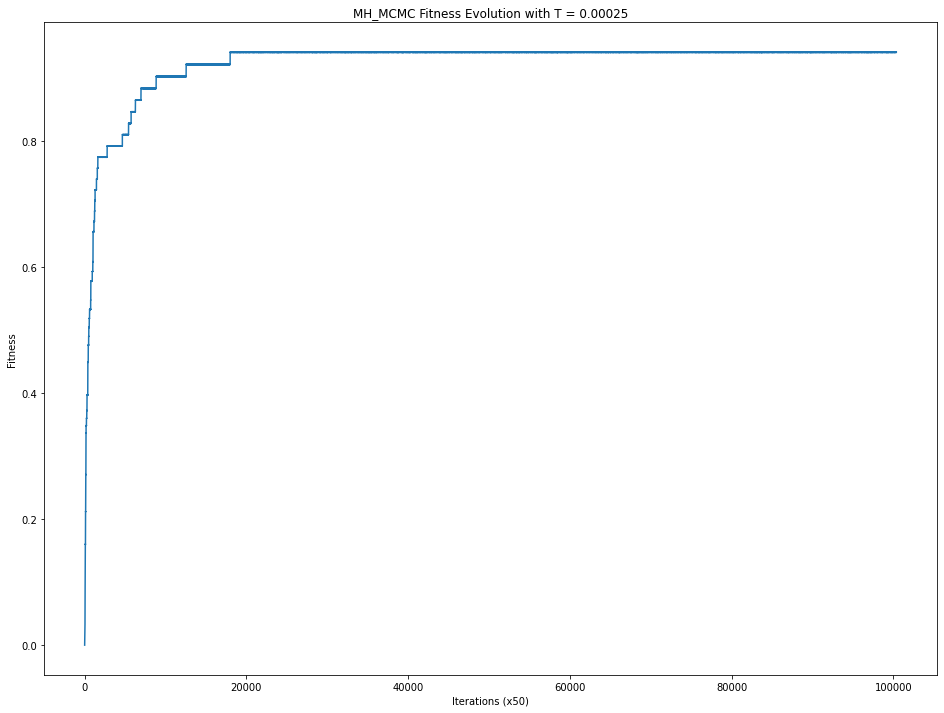

In [7]:
#test for a longer sequence
sequence = generate_random_sequence(200)
MH_MCMC(sequence, toy_fitness_2, no_of_iterations,
        convergence_known = True, plot_fitness = True, 
        verbose = False, temp = 2.5e-4)[0]

'AGAGAGAGAGGAGVCVCVCSAGVCAGVCVCVCVCAGVCVCVCQAGVCAGAGAGAVCAGAGAGAGVCVCVCVCVCAGVCVCAGAGVCVCVVCAGVCVCAGAGAGAGVCAGAGVCAGAGVCVCVCVCVCVCAGVCAGAGVCVCVCAGAGVCVCVCAGVCVCVCAGVAGHVCVCVCVCVCIVCVCAGAGVCVCVCVCAGAGDVCVCVCAGVCVCAGAGAGAGVCVCVCVCAGAGVCVCVCVCAGVCVCVCVCAGAGAGAGAGAGAGVCAGAGAGAGAGAGAGVCVCVCAGTVCAGAGVCAGVCAGAGAGAGVCVCVCAGVCVAGVCAGAGVCAAGAGVCAGAGNAGVCVCVCAGVCAGAGVCVCAGVCVCIAGVCVCVCAGAGAGTVCVCVCAGVCEVCAGVCVCAGVCIAGAGVCAGMAGVCAGAGVCVCVCAGNVCVCVCVCAGAGVCAGVCAGAGAGVCYAGAGVCAGAGVCAGAGVCVCVCAGVCAGVCVCAGVCAGVCEVCEAGVCAGTVCVCAGAGAGVCAGAGAGAGAGVCVCAGAGAGAGVCVCVCAGVCVCVCAGVCVCVCAGAGAGAGAGAGVCVCVCAGAGVCAGVCAGAGVCVCAGAGVCAGAGAGVCVCAGVCVCVCAGVCAGAGAGAGAGGAGAGVCVCVCVCVCPAGAGVCAGAGIAGAGAGAGAGVCVCAGVCAGVCAGVCVCAGVCVCAGAGAGAGVCAGVCAGVCVCAGVCAGVCAGMAGAGFAGAGAGVCVEAG'

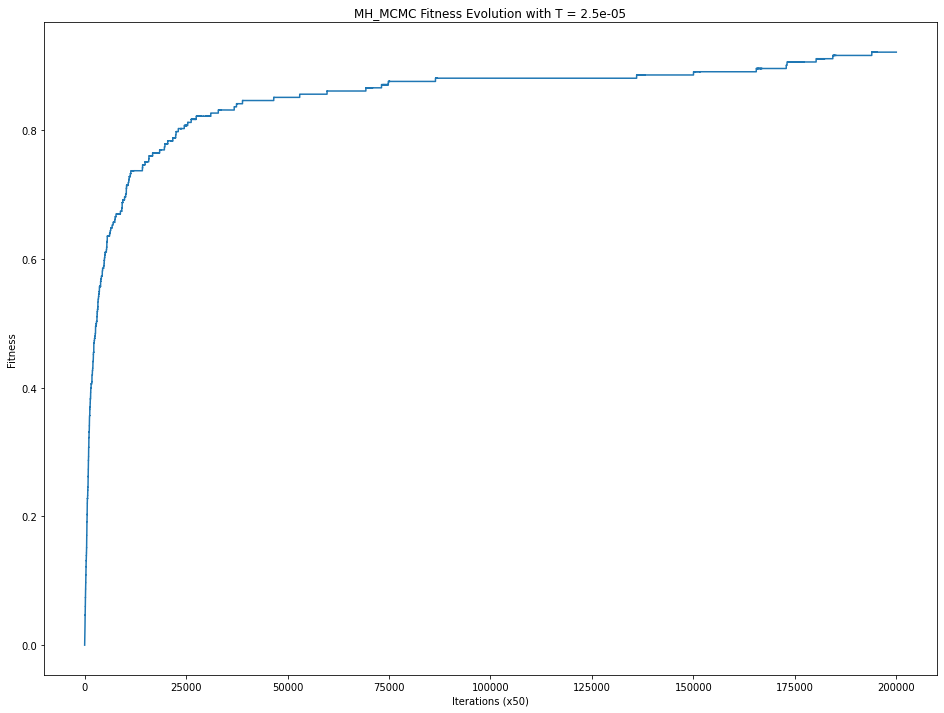

In [8]:
#test for an even longer sequence
sequence = generate_random_sequence(750)
MH_MCMC(sequence, toy_fitness_2, no_of_iterations, 
        convergence_known = True, plot_fitness = True, 
        verbose = False, temp = 2.5e-5)[0]

## Fitness Function Considerations and Future Directions

For any MCMC run to be successful, we need certain conditions to hold. In the ideal case, they are that, 

1. The fitness function is 'approximately continuous, connected, and spans the full fitness space between 0 and 1'. This is important because we want to ensure that there exists a path from low fitness to high fitness that is achievable via a good ratio of accepted and rejected monte carlo moves. 
2. The choice of temperature (or the temperature ladder) is such that the ratio of accepted to rejected moves is approximately 23-30%. For PT/RE, the there must be an 'overlap' of about 20% in the $r_{re}$ distribution for a given move. In unphysical systems, it is often challenging to achieve this due to the highly varying resolution of the fitness function. So while this is a desired quality for reaping the full advantages of RE/PT, it does not hinder it's ability to reach convergence.
3. For ideal computational performance, an implementation of instance specific parallel processing. 

## Evolutionary MCMC (EMC)

EMC is a series of four steps, repeated until convergence. 

1. Mutation step(s): Take multiple sequences, and you mutate them independantly using the MH rule. This can be repeated n number of times.  
2. Crossover step: (Tim) after a set number of iterations select two sequences from two different chains, Si and Sj, according to their Boltzmann-weighted fitness (or entirely randomly).  We next crossover the two sequences, that is we take positions n:m of the two sequences (assuming the sequences are the same length) and we exchange the subsequences of the two sequences to generate two new sequences Ri and Rj
3. Crossover step continued: We accept, or reject these new sequences Ri and Rj, according to another MH rule.
4. Swap step: Two sequences, at random, may be swapped between chains i and j, according to another MH rule.
5. Repeat, until convergence is reached

The complete implementation has each sequence mutated independantly at different temperatures and then crossed over at random according to their respective MCMC rules (Liang and Wong). In replica-exchange/parellel-tempering, the crossover step is skipped and only swaps between different chains at different temperatures are evaluated. 

(Side note, due to the large number of outputs, we will rewrite these functions as classes, I'm keeping these as functions for testing and evaluations) 

## Parallel Tempering Tests

Recall that EMC without the crossover step is just parallel tempering. Let's test a few implementations of this. 

['AGAGAGAGVCAGVCAGSCAGLVCVCVCQAGVCAGIPIDAGMAGEVCWAGRVCVCLRAGEVCQGHAGSAGRPMNIAGVCAGKVCAAGVCCAGDAGIEGVAGVCAGAGEAGHDVCYLKVCVCAHVCPQDVCGLVCVCVCMVCHDVCVCAVCNNMTAGAGAGVCAGTAGVCAGNCAGQVCAGVCSVCVCMCVCHAGFWVCGIVCVCCAGAGAGAGAGAGVCVYVCVCAGRAGCYAGVCVCWVCIAGAGWMEMAGAGVCVCAGFVCVCVCVCKVCAGNNVCVCVCPEAGVCVCAGFLPVCVCVCAGLPAGAGGAGVAGAGVCPQAGAVCAGVCAGQVCNVCAGVCPVCCAGSAGVCINYAGVCSAGWVCTVCPKVCAGQNAGIAGFAGAGAGNVCVCPVCVCCVCQREAGAGTVAGKVCAGAAGVCAGSEVCAGVCPAGAGWAGPCVCVCVCQFAGQAGAGVCSAGGAGSVCAGAGAGVCYNVCAGVCPVCVCAGVCTTKCYAG', 'CAGAGVCAGAGVCVCCVCRTAGYAGAGVCCSWVCMVFVCNAGEDVCAGMVCDCEAGPYAGSTVCAGVCAGAGYVCAGVCVCSVCVCWVCVVCCSLYVMHVCISVCRIWKGPTVCVCKIVCVCAGQAGGAGPEVCQRVCVCQVCAGAGIVCAGAGRVCTPNVCAGTVCVCIAGVCLNLVCREVCVCVCVCAGAGPAGVCAGGVCEVCAGAGIVCAGWQAVCAGIAGAGVCLVCADMVCGVCVCAGYMVVCAGAGAGVCLYVCIAGAGVCVCAGAGQAGAGSAGAGNDIVCTVVCAGCVCMAGVCLIAGAAGSVCVCVCVCCAGAGVCHAGAGVCEVCREAGVCAGVVCAVCVCSVCVCWAGAGAGFAGVCAGFGEVCMIKAGAGVCAGVCCVCAGVCAGVCVCAGGYAGRQDEFCNGNAGFAGAGAGKVCVCMAGVCIVCHVCGVCCVVCVCNVCAGVVCAGNLVCRWEIVCAGTAGVCVCAGAVCNVCAGNVCY

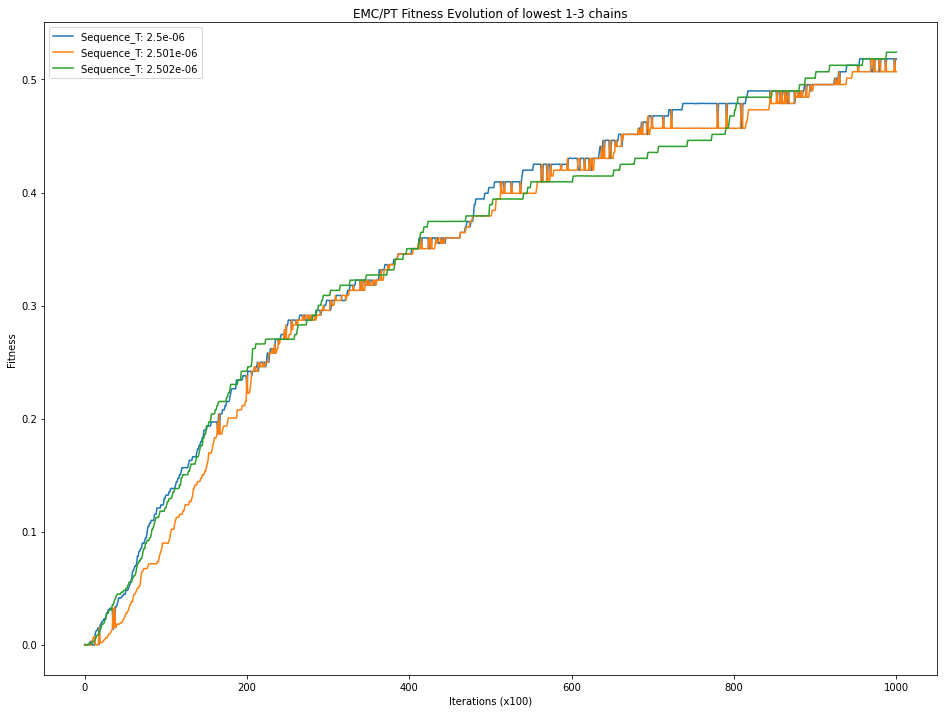

In [9]:
no_of_iterations = 10**5 #100k
sequence_1 = generate_random_sequence(500)
sequence_2 = generate_random_sequence(500)
sequence_3 = generate_random_sequence(500)
sequence_4 = generate_random_sequence(500)
sequence_list = [sequence_1, sequence_2, sequence_3, sequence_4]

temp_list = [2.5e-6, 2.501e-6, 2.502e-6, 2.503e-6]

test = emc_v2(sequence_list, toy_fitness_2, 
              no_of_iterations, 
              temp_list, 
              convergence_known = True, 
              crossover_rate = 0, #this makes this RE/PT 
              swap_events = 2,
              n_mutations = 5,
              plot_fitness = True)

print(test[0], test[1][-1])
# test = emc_v1(sequence_1, sequence_2, toy_fitness_2, 10**6, 10, temp = 2e-5, plot_fitness = True)
# None

['VCFVCCAGAGVCCMVCKAGAGLVCVCRVCDAGHLYVCLCVCHVCEGIAGIVCAGNVCVCMVCMGDVCADVCPVCAGCAGAGIWLAGHVCERDDAGLRMFRHQVCVCCVCVVCAGHAGAGMRFVCVFVCVCKDEMYVCWVCAGAGHAGDHIAGVCAGAGVCVCVCAGAGAGAAGAGVCVCAGWAGVCVCPTAGAGMVPVCPAGVCAGAGAGRVCYITDPAGKVIVCTAGVCKVCNVCKFDVCVCEGDVCNVCVVCAGVCEAGVCPVCAGVCNVCAAGAAGVCAGTVCAGSVCAGQWEDIFAGQPAGAGRAGKAGAGHMSVCVCKAGLVCWNAGVCVCMPAGVCKSAGVCHAGVCAGAVCAVCPVCVVCAGSAGVCAGMAVCVCQADHVCQVCVCAGVCAGVCVCTARVVCMAGSTAGVCNAGDAGAVCVCKVCAGVCSVCVAGDFTAGAGSVCAGVCPKGAAGLYYIAGQTAAGTVCAGVCPQSTAGVCVCIVCVCVCVCRFAGYHPIMVCQAGAGPAGVCVCVCVCKYAGWASAGAGWAGDAIRVCVCTVCFVCNAGVCVCAGPVCQEVCAGAGGGPVCTWSGLIVCVAGQAGVCMAGSPVCVCGYTEVCDKVCVCAGVCAGAGAGYVCSAGCAGVCLLAGIAGCAGAGFVCVCKVCHMVCGAGNVVCSRVCAGDAVCAGVCIAGAGIVCPAGAGAGFVCYAGAGFRVCYVCVCWMAGAGAGPVCQAGVCSMRQVCLTAGVCVCAGAGIC', 'DVPHAGQAGQWVCRTKAHKCAGTVCVHDPVCAVCLAGVCSAGQAGAGVCINAGVCMVCVCMSAGVCSLPDVCHDVCVCVCVDVCAGVAGADKVCAGQLVCSVCYDVCDAGAGSPSWMAGAGKVVCVGNPIIVCAGAGNVCAGAGVCAGEYHAGAGTAGTTDSVCVCYAGVCDGVCRVCVCVCAGVCVCQAGIVCVCAGFAGAGAGTTAAGIHVCVCKVCSAGAAGSMAGNSKRVAGDVCAGVCW

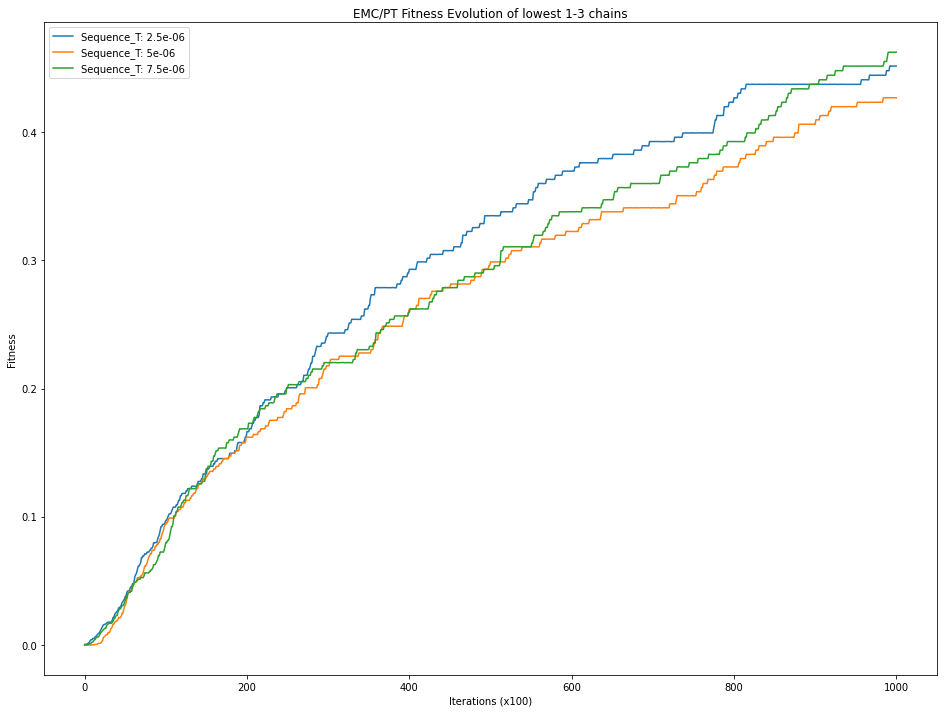

In [10]:
no_of_iterations = 10**5 #100k
sequence_1 = generate_random_sequence(750)
sequence_2 = generate_random_sequence(750)
sequence_3 = generate_random_sequence(750)

sequence_list = [sequence_1, sequence_2, sequence_3]

temp_list = [2.5e-6, 5e-6, 7.5e-6]

test = emc_v2(sequence_list, toy_fitness_2, 
              no_of_iterations, 
              temp_list, 
              convergence_known = True, 
              crossover_rate = 0, #this makes this RE/PT 
              swap_events = 2,
              n_mutations = 5,
              plot_fitness = True)

print(test[0], test[1][-1])
# test = emc_v1(sequence_1, sequence_2, toy_fitness_2, 10**6, 10, temp = 2e-5, plot_fitness = True)
# None

['VCVCVCAGVCAGAGAGAGKVCAGVCAGVCVCVCVCAGAGYAGVCPAGVCAGAGGVCVCVVCVCVCVCVCVCAGVCVCAGVCVCWAAGAGVCTVCAGVCVCAGVCAGAGAGGVCVCAGVCEAGVCAGVCVCAGAGVCAGVCVCEIAGVCAGAGAGAGCVCAGVCVCVCAGAGVCMVCAGVCVCVCQVCAGVCAGVCAGAGVCVCAGAGVCAGAGSAGAGVCAGVCAGAGAGAGAGVCEAGAGTAGAGVCVCVCVCVCAGAGVCVCAGAGSVCAGAGVCVCVCAGAGVCLAGAGVCCVCAGVCVCVAGAGTVCVCVCAGVCPAGVCVCAGAGLAGVCVCNVCAGAGAGVCAGAGAGAGVCVCVCCAGVCAGVCVCVCAGDVCVCAGAGVCAGAGVCAGAGAG', 'CVCVCNVCAGVCAGAGVCYVCAGVCYVCAGVCVCTVCVCAGAGAGVCVCAGVCVCAGFAGVCVCAGVCAGAGAGVCVCEVCVCVCVCRAGAGAGVCAGAGVCAGAGAGAGVCVCAGVCVCVCAGVCAGVCDVCAGVCVCMVCVCVCAGAGAGVCVCVCAGVCAGAGAGVCAGAGAGGAGVCVCGVCAGVCMAGVCAGVCAGAGAGAGAGAGVCVCAGFAGAGAGVCVCGAGAGDVCVCAGAVCVCVCVCAGVCVCVCAGAGVCVCYAGAGVCVCAGVCVCVCGAGAGVCAGAGAGVCAGAGVCAGVCVCNVCVVCVAGVCAGAGVCAGVCVCVCQVCAGAGAGAGVCAGAGVCVCVCAGVCTAGVCVCAGAGQAGAGVCAGAGVCVCAGAGAGVCGVCAG'] [0.86480269 0.87404475]


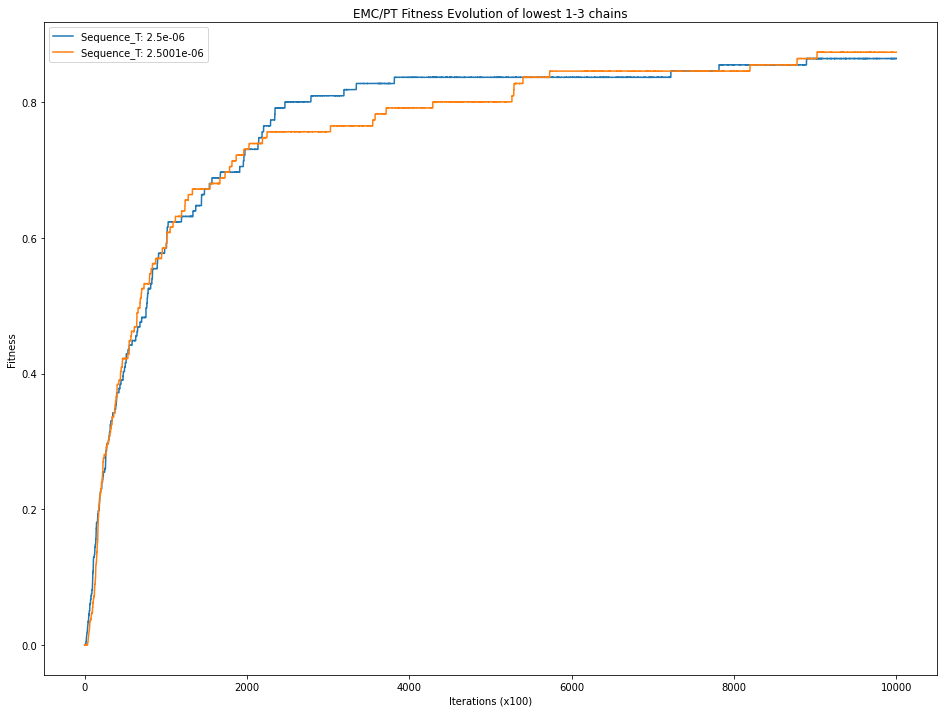

In [11]:
no_of_iterations = 10**6 
sequence_1 = generate_random_sequence(400)
sequence_2 = generate_random_sequence(400)


sequence_list = [sequence_1, sequence_2]

temp_list = [2.5e-6, 2.5001e-6]

test = emc_v2(sequence_list, toy_fitness_2, 
              no_of_iterations, 
              temp_list, 
              convergence_known = True, 
              crossover_rate = 0, #this makes this RE/PT 
              swap_events = 1,
              n_mutations = 3,
              plot_fitness = True)

print(test[0], test[1][-1])
# test = emc_v1(sequence_1, sequence_2, toy_fitness_2, 10**6, 10, temp = 2e-5, plot_fitness = True)
# None

## EMC Tests

Now let us allow crossover steps to take place and see the evolution of the fitness functions. 

/Users/zakijawaid/Desktop/Jupyter_Notebooks/github_stuff/crispy_code/MCMC_Development/explore_fitness.py:472: RuntimeWarning: overflow encountered in exp
  swap_probability = min(1, np.exp((new_fitness_1 - fitness_1)/temp1 - (new_fitness_2 - fitness_2)/temp2))


['AGAGVCVCVCVCAGAGAGAGAGVCAGVCAGWVCAGAGAGVCVCAGAGIAGAGAGNAGAGAGAGAGYVCVCVCVCVCAGVCAGAGVCVVCVCAGAGAGAGSAGVCAGVCVCVCVCAGVCVCVCAGAGVCAGQAGVCAGAGVCVCAGAGVCEAGVCAGAGAGAGAGPAGVCAGVCVCDAGAGAGAGVCAGAGLAGVCAGVCVCVCAGSAGAGAGVCAAGAGVCVCVCVCVCAGAGAGAGVCAGDVCAGVCVC', 'VCVCAGVCELVCCVCVCAGAGLVCVCVCHAGVCAGVCWAGAGVCMAGVCVCGFAGAGAGAGVCAGAGAGMAGVCAGEVCAGAGVCAGAGAAGAGVCVCPVCVCAGAGAGAGWVCVCVAGAGVCVCVCVCVCTAGIEAGAGAGVCAGAGVAGVCVCPAGYCVCAGAGFAGVCIVCVCVCVCAGVCRVCAGFVCRVCAGAGAGVCVCAWAGLVCAGTAGAGAGVCVCVCAGAGVCAGVCVCAGAVCVCVCAG'] [0.89103331 0.7600719 ]


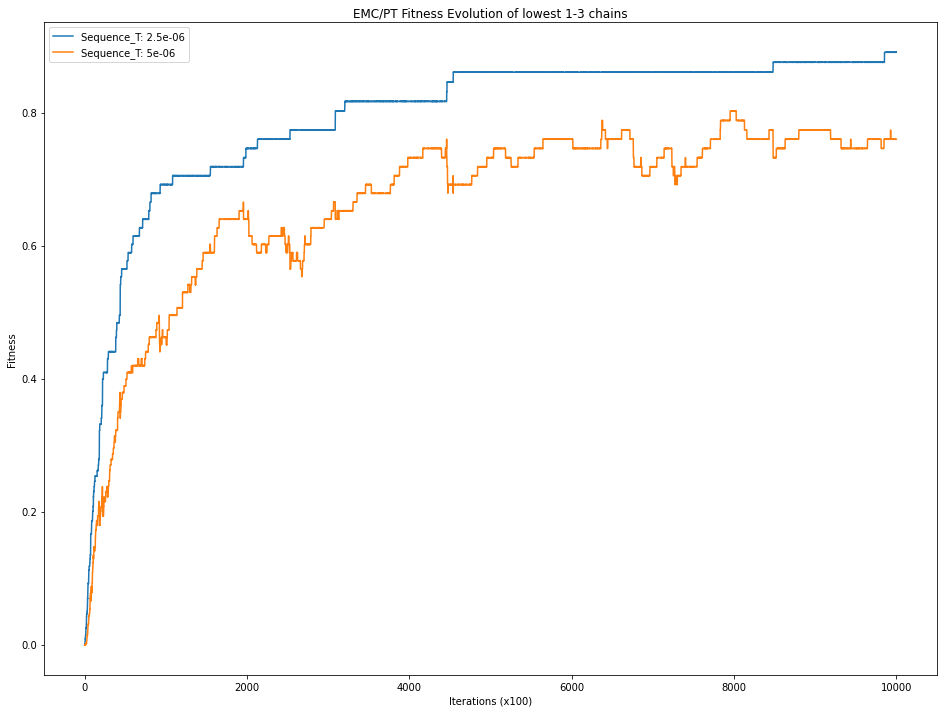

In [12]:
no_of_iterations = 10**6 
sequence_1 = generate_random_sequence(250)
sequence_2 = generate_random_sequence(250)

sequence_list = [sequence_1, sequence_2]

temp_list = [2.5e-6, 5e-6]

test = emc_v2(sequence_list, toy_fitness_2, 
              no_of_iterations, 
              temp_list, 
              convergence_known = True, 
              crossover_rate = 0.25,  
              crossover_events = 1,
              n_mutations = 3,
              plot_fitness = True)

print(test[0], test[1][-1])
# test = emc_v1(sequence_1, sequence_2, toy_fitness_2, 10**6, 10, temp = 2e-5, plot_fitness = True)
# None

['VCAGVCVCHAGQAGAGAGAGAGVCVCVCAVCAGVCVCYMVCAGAGAGAGAGVCAGAGVCAGAGSAGVCAGYAGAGVCVCWAGVCKAGAGSVCCRVCAGSMAGVCAGVCVCAVCLWVCVCAGAGAVCGAGVCVCAGAGVCAGQAGLVCPVCVCAGAGVCEMIAAGAGAGAGVCVCVCAGFIVCVCVCVCVCAGVCYAGVCVCAGAGAGKAGGVCVCVCVCVCAGSVCGVCAGCAGVCVCAGRVCAGAGPAG', 'AGVCVCSAGMAGPVCVCVCFVCAGWVVCYAGVCAGAGPAGVCYKIPAGAYWVCIAGAVCAGAGAGVCAGVCWVCAGVCQVCAGVCAGAGAGEQAGCAGALAGVCAGKVCWAGNWAGVCPVCMAGAGAGVCSVCEVCAGPVCAGVCVCVCVCVCVCAGVCQVCAGAGVCAGGVCCLAGAGVCVCVCAGAGVCAGVCVCEVCLVCAGAGAGTAGFAGGVCVCGVAGAGAGYPSDPLPPVCGAGAGVCYRNVC', 'AGPDAGDAGVCYRAGMKYNKMVCRAGKAGEAGPTVCAGLQAGDVCDVCPVCVCPIKEEVCVCAGVCYAGAGPAGCAGTVCAGTGAGHVCVAGICVCVCVCHVCGFVCYAGDAGKMVCIAGVCPAGAGVCVCAGVCPMVCAAGRVCTVCQVCAGGAAVCVCVCAGKAGVCVCEVCVCVCVCMAGVCNVCAGVCVCGNEVVCAGFAGYAGAGPAGEHAGDAGVCVMAGAGIAPWCSVCVCVYNPAGYHVTTR'] [0.73235391 0.60173509 0.43009139]


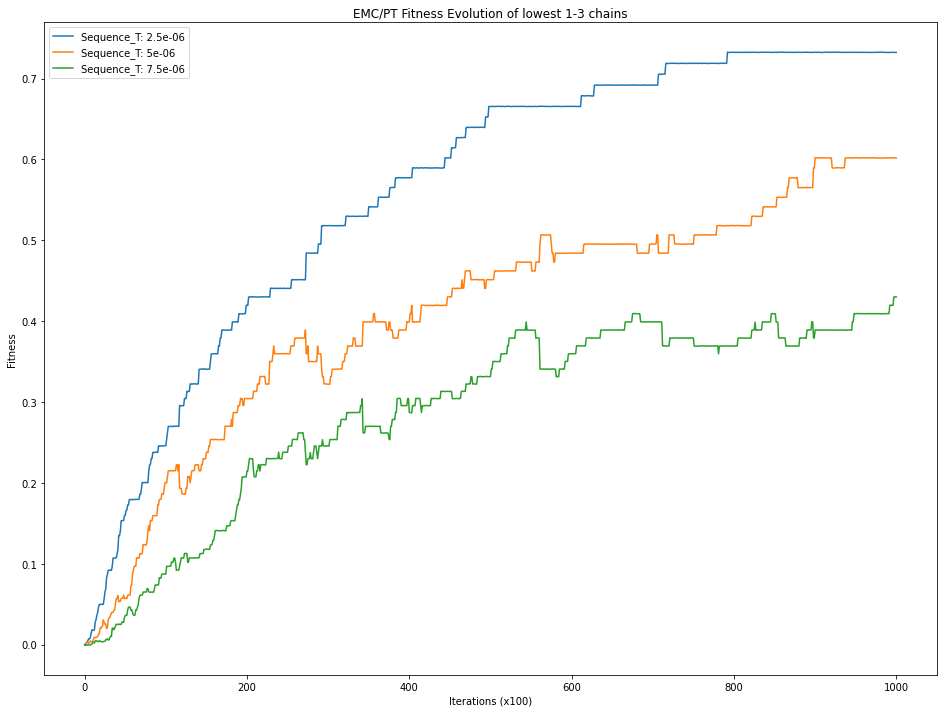

In [13]:
no_of_iterations = 10**5
sequence_1 = generate_random_sequence(250)
sequence_2 = generate_random_sequence(250)
sequence_3 = generate_random_sequence(250)

sequence_list = [sequence_1, sequence_2, sequence_3]

temp_list = [2.5e-6, 5e-6, 7.5e-6]

test = emc_v2(sequence_list, toy_fitness_2, 
              no_of_iterations, 
              temp_list, 
              convergence_known = True, 
              crossover_rate = 0.2,  
              crossover_events = 1,
              n_mutations = 3,
              plot_fitness = True)

print(test[0], test[1][-1])
# test = emc_v1(sequence_1, sequence_2, toy_fitness_2, 10**6, 10, temp = 2e-5, plot_fitness = True)
# None